## Libraries

In [1]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset

## Looking at the data

In [2]:
dataset = pd.read_csv('files/data.csv')
dataset.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


1. I want a Neural Network to predict the total number of rented bikes
2. I want to create two Neural Networks to predict casual rented and registered rented and sum their predictions to get total predictions

## Cleaning the data

In [3]:
cnt_cleaned_dataset = dataset.copy().drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=False)
casual_dataset = dataset.copy().drop(['instant', 'dteday', 'registered', 'cnt'], axis=1, inplace=False)
registered_dataset = dataset.copy().drop(['instant', 'dteday', 'casual', 'cnt'], axis=1, inplace=False)

print(cnt_cleaned_dataset.head())
print(casual_dataset.head())
print(registered_dataset.head())

   season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0       1   0     1   0        0        6           0           1  0.24   
1       1   0     1   1        0        6           0           1  0.22   
2       1   0     1   2        0        6           0           1  0.22   
3       1   0     1   3        0        6           0           1  0.24   
4       1   0     1   4        0        6           0           1  0.24   

    atemp   hum  windspeed  cnt  
0  0.2879  0.81        0.0   16  
1  0.2727  0.80        0.0   40  
2  0.2727  0.80        0.0   32  
3  0.2879  0.75        0.0   13  
4  0.2879  0.75        0.0    1  
   season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0       1   0     1   0        0        6           0           1  0.24   
1       1   0     1   1        0        6           0           1  0.22   
2       1   0     1   2        0        6           0           1  0.22   
3       1   0     1   3        0        6    

## Preparing data for training and evaluation

In [4]:
def create_tensor_dataset(values,device):
    x = values.values[:, :-1]
    y = values.values[:, -1]

    dataset = TensorDataset(torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device))
    return dataset

def create_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def split_data(dataset, test_size, random_state):
    x_train, x_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test

## Setting a Manual Seed

In [5]:
RANDOM_SEED = 42
RANDOM_STATE = 42

torch.manual_seed(RANDOM_SEED)

# cnt_cleaned_dataset train and test set
x_train, x_test, y_train, y_test = split_data(cnt_cleaned_dataset, 0.2, RANDOM_STATE)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8708, 12), (2178, 12), (8708,), (2178,))

## Training Loop

In [6]:
def train_model(given_model, train_loader, optimizer, loss_fn, epochs) -> nn.Module:
    losses = []

    given_model.train()
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()

            y_pred = given_model(x_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            loss.backward()

            optimizer.step()

        if epoch % 10 == 0:
            predicted_loss = loss.item()
            print(f'Epoch: {epoch}, Loss: {predicted_loss}')
            losses.append(predicted_loss)

    return given_model, losses

## Evaluation

In [7]:
def evaluation(given_model, test_loader, loss_fn, verbose=False) -> tuple:
    predictions = []
    losses = []


    given_model.eval()
    with torch.no_grad():
        for x_test_tensor, y_test_tensor in test_loader:
            y_pred = given_model(x_test_tensor)

            predictions.append(y_pred.item())

            loss = loss_fn(y_test_tensor, y_pred)
            losses.append(loss.item())

            if verbose:
              print(f'Loss: {loss.item()} -- Predicted: {y_pred.item()} -- Actual: {y_test_tensor.item()} -- Difference: {round(abs(y_test_tensor.item() - y_pred.item()),2)}')

    return predictions, losses


## Prediction

In [8]:
def predict_on_evaluation_set(given_model, eval_set):

    predicted_values = []

    given_model.eval()
    with torch.no_grad():
        predictions = given_model(eval_set)

        for item in predictions:
            predicted_values.append(item.item())

## Evaluation Set

In [9]:
eval_dataset = pd.read_csv('files/evaluation_data.csv')

if 'dteday' in eval_dataset.columns:
    eval_dataset.drop(['dteday'], axis=1, inplace=True)

eval_dataset_tensor = torch.from_numpy(eval_dataset.values).float()

## Plotting Functions

In [10]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(20, 10))
    pred_number = range(len(y_true))
    plt.scatter(pred_number, y_true, label='Actual values', color='lightgreen')
    plt.scatter(pred_number, y_pred, label='Predicted values', color='red', linestyle='dashed', alpha=0.7)
    plt.title(title)
    plt.xlabel('Number of predictions')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

def plot_loss(losses, title):
    epochs = range(len(losses))
    epochs = [epoch * 10 for epoch in epochs]
    plt.figure(figsize=(20, 10))
    plt.plot(epochs, losses, label='Loss', color='blue')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Device and loss rmsle loss function for evaluation

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')


def rmsle(y_true, y_pred):
    y_pred = torch.clamp(y_pred, min=0)
    log_true = torch.log(y_true + 1)
    log_pred = torch.log(y_pred + 1)
    msle = torch.mean((log_pred - log_true) ** 2)
    return torch.sqrt(msle)

Using cuda device


# 1. Predict based only on Total Number

## Preparing CNTBikeRentingPredictor (1 Hidden Layer)

In [ ]:
class CNTBikeRentingPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNTBikeRentingPredictor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.actv = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.fc2(x)
        return x

### First test:
- 1 hidden layer
- relu activation function
- learirn rate = 0.02
- 20 hidden nodes
- batch size = 32

In [ ]:
INPUT = cnt_cleaned_dataset.shape[1] - 1
HIDDEN = 20
OUTPUT = 1

EPOCHS = 401
BATCH_SIZE = 32

cnt_model = CNTBikeRentingPredictor(INPUT, HIDDEN, OUTPUT).to(device)

model_parameters = cnt_model.parameters()
optimizer = torch.optim.Adam(model_parameters, lr=0.02)
loss_fn = nn.MSELoss()

# training cnt_model
train_dataset = create_tensor_dataset(cnt_cleaned_dataset, device=device)
train_loader = create_dataloader(train_dataset, BATCH_SIZE)


# evaluation
test_dataset = TensorDataset(torch.from_numpy(x_test.values).float().to(device), torch.from_numpy(y_test.values).float().to(device))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



In [ ]:
# training
model_v1, train_losses = train_model(cnt_model, train_loader, optimizer, loss_fn, EPOCHS)

# evaluation
predictions, losses = evaluation(model_v1, test_loader, rmsle)


Epoch: 0, Loss: 37616.26171875
Epoch: 10, Loss: 36022.08984375
Epoch: 20, Loss: 32504.00390625
Epoch: 30, Loss: 31565.14453125
Epoch: 40, Loss: 31873.85546875
Epoch: 50, Loss: 31392.203125
Epoch: 60, Loss: 31348.25390625
Epoch: 70, Loss: 31826.82421875
Epoch: 80, Loss: 31911.61328125
Epoch: 90, Loss: 31372.146484375
Epoch: 100, Loss: 31583.546875
Epoch: 110, Loss: 31648.6796875
Epoch: 120, Loss: 24877.388671875
Epoch: 130, Loss: 16765.31640625
Epoch: 140, Loss: 13459.5546875
Epoch: 150, Loss: 10965.138671875
Epoch: 160, Loss: 9154.58203125
Epoch: 170, Loss: 8043.078125
Epoch: 180, Loss: 7355.125
Epoch: 190, Loss: 6807.86669921875
Epoch: 200, Loss: 6571.5693359375
Epoch: 210, Loss: 6318.9091796875
Epoch: 220, Loss: 6242.365234375
Epoch: 230, Loss: 6140.4775390625
Epoch: 240, Loss: 6193.892578125
Epoch: 250, Loss: 6086.794921875
Epoch: 260, Loss: 6098.88232421875
Epoch: 270, Loss: 6141.0498046875
Epoch: 280, Loss: 6061.6015625
Epoch: 290, Loss: 6072.08740234375
Epoch: 300, Loss: 6052.444

In [ ]:
len(train_losses)

41

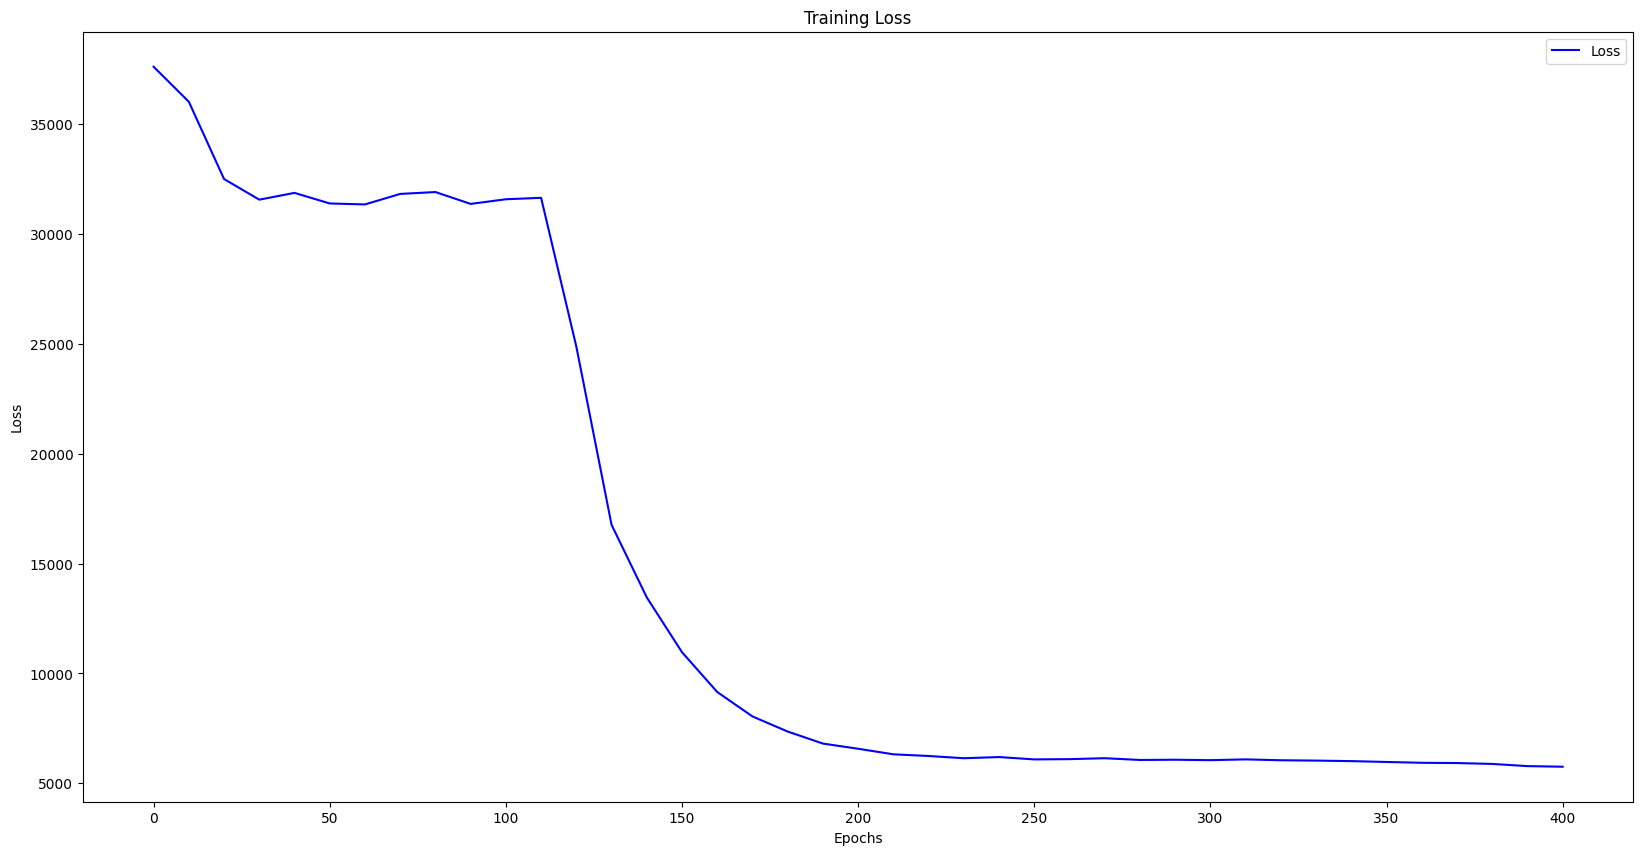

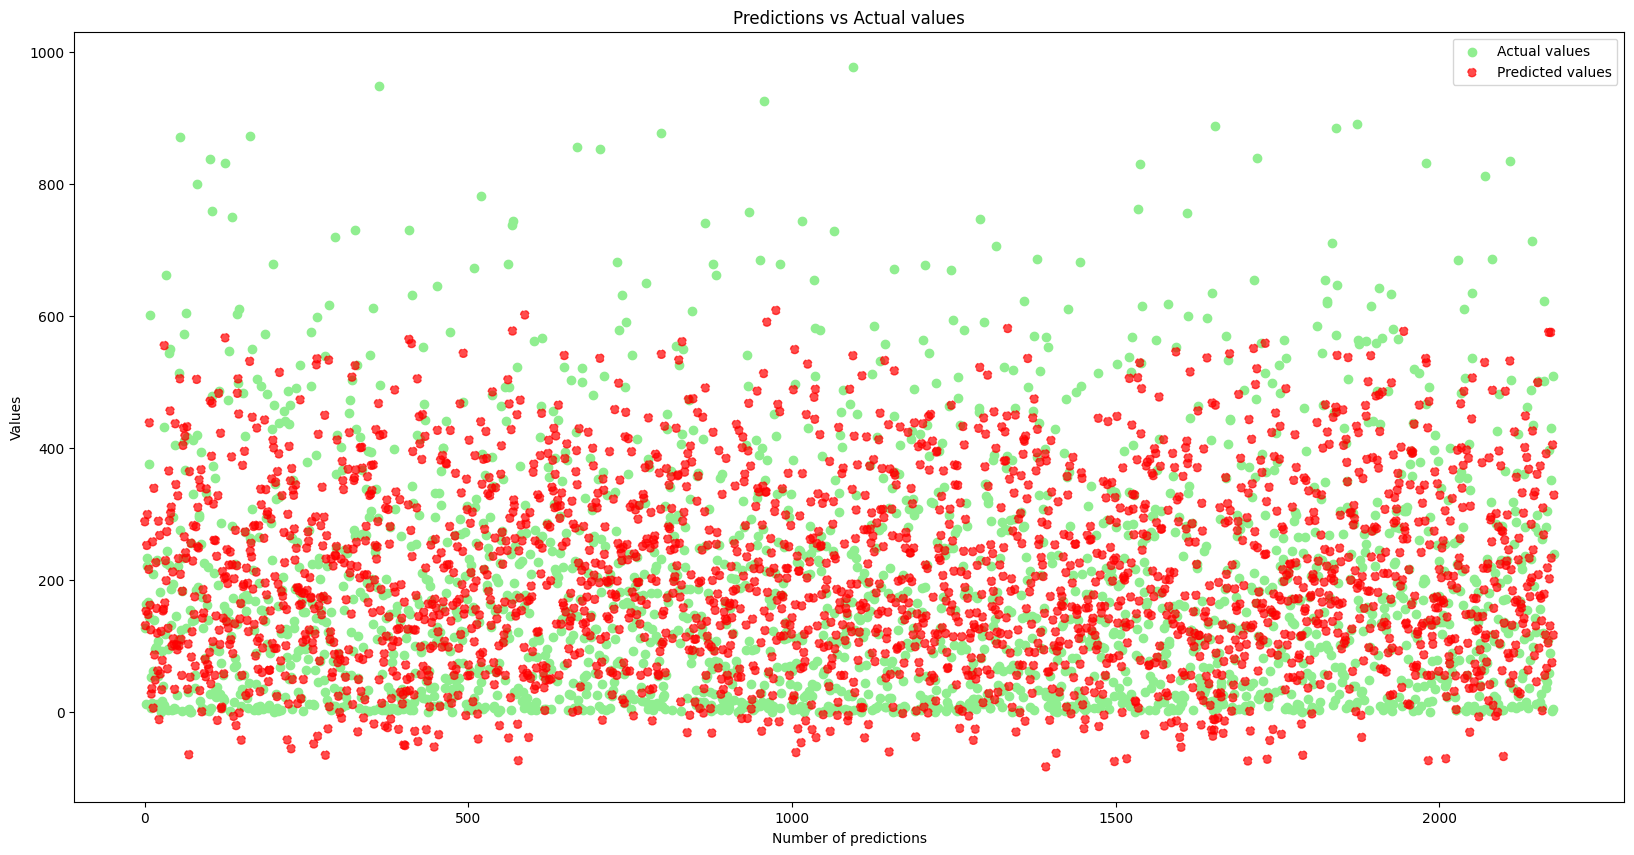

In [ ]:
plot_loss(train_losses, 'Training Loss')
plot_predictions(y_test, predictions, 'Predictions vs Actual values')

### Second test - testing hidden nodes
- 1 hidden layer
- relu activation function
- learirn rate = 0.02
- batch size = 32
- hidden nodes from 25 - > 60

In [ ]:
hidden_nodes = [25, 30, 35, 40, 45, 50, 55, 60]
learning_rate = 0.02

torch.manual_seed(RANDOM_SEED)

EPOCHS = 401

hidden_trained_models = {}
hidden_trained_losses = {}
hidden_avg_eval_losses = {}
hidden_predictited_values = {}

for hidden in hidden_nodes:

    print(f'Training model with {hidden} hidden nodes')

    trained_model = CNTBikeRentingPredictor(INPUT, hidden, OUTPUT).to(device)
    model_parameters = trained_model.parameters()
    optimizer = torch.optim.Adam(model_parameters, lr=learning_rate)
    loss_fn = nn.MSELoss()

    # training
    trained_model, train_losses = train_model(trained_model, train_loader, optimizer, loss_fn, EPOCHS)

    # evaluation
    predictions, losses = evaluation(trained_model, test_loader, rmsle)

    hidden_trained_models[hidden] = trained_model
    hidden_trained_losses[hidden] = train_losses
    hidden_avg_eval_losses[hidden] = np.mean(losses)
    hidden_predictited_values[hidden] = predictions





Training model with 25 hidden nodes
Epoch: 0, Loss: 37001.796875
Epoch: 10, Loss: 36427.8671875
Epoch: 20, Loss: 32670.12890625
Epoch: 30, Loss: 31077.71875
Epoch: 40, Loss: 31083.92578125
Epoch: 50, Loss: 30855.068359375
Epoch: 60, Loss: 31366.703125
Epoch: 70, Loss: 20485.34375
Epoch: 80, Loss: 19938.546875
Epoch: 90, Loss: 19856.26171875
Epoch: 100, Loss: 20033.650390625
Epoch: 110, Loss: 17641.373046875
Epoch: 120, Loss: 14665.0107421875
Epoch: 130, Loss: 11291.7373046875
Epoch: 140, Loss: 9256.05078125
Epoch: 150, Loss: 8213.9755859375
Epoch: 160, Loss: 7656.58349609375
Epoch: 170, Loss: 7412.8154296875
Epoch: 180, Loss: 7148.34521484375
Epoch: 190, Loss: 7040.3447265625
Epoch: 200, Loss: 6768.5400390625
Epoch: 210, Loss: 6514.810546875
Epoch: 220, Loss: 6447.07568359375
Epoch: 230, Loss: 6286.59912109375
Epoch: 240, Loss: 6347.484375
Epoch: 250, Loss: 6259.6044921875
Epoch: 260, Loss: 6348.37060546875
Epoch: 270, Loss: 6410.36083984375
Epoch: 280, Loss: 6553.88037109375
Epoch: 29

Average loss on test set on hidden : 25 nodes is 0.6546600516834207
Average loss on test set on hidden : 30 nodes is 0.8724681743248763
Average loss on test set on hidden : 35 nodes is 0.8831182830480395
Average loss on test set on hidden : 40 nodes is 0.757784623416659
Average loss on test set on hidden : 45 nodes is 0.7118457887455123
Average loss on test set on hidden : 50 nodes is 0.9144411328957648
Average loss on test set on hidden : 55 nodes is 0.7081473544171581
Average loss on test set on hidden : 60 nodes is 0.7405790806473451


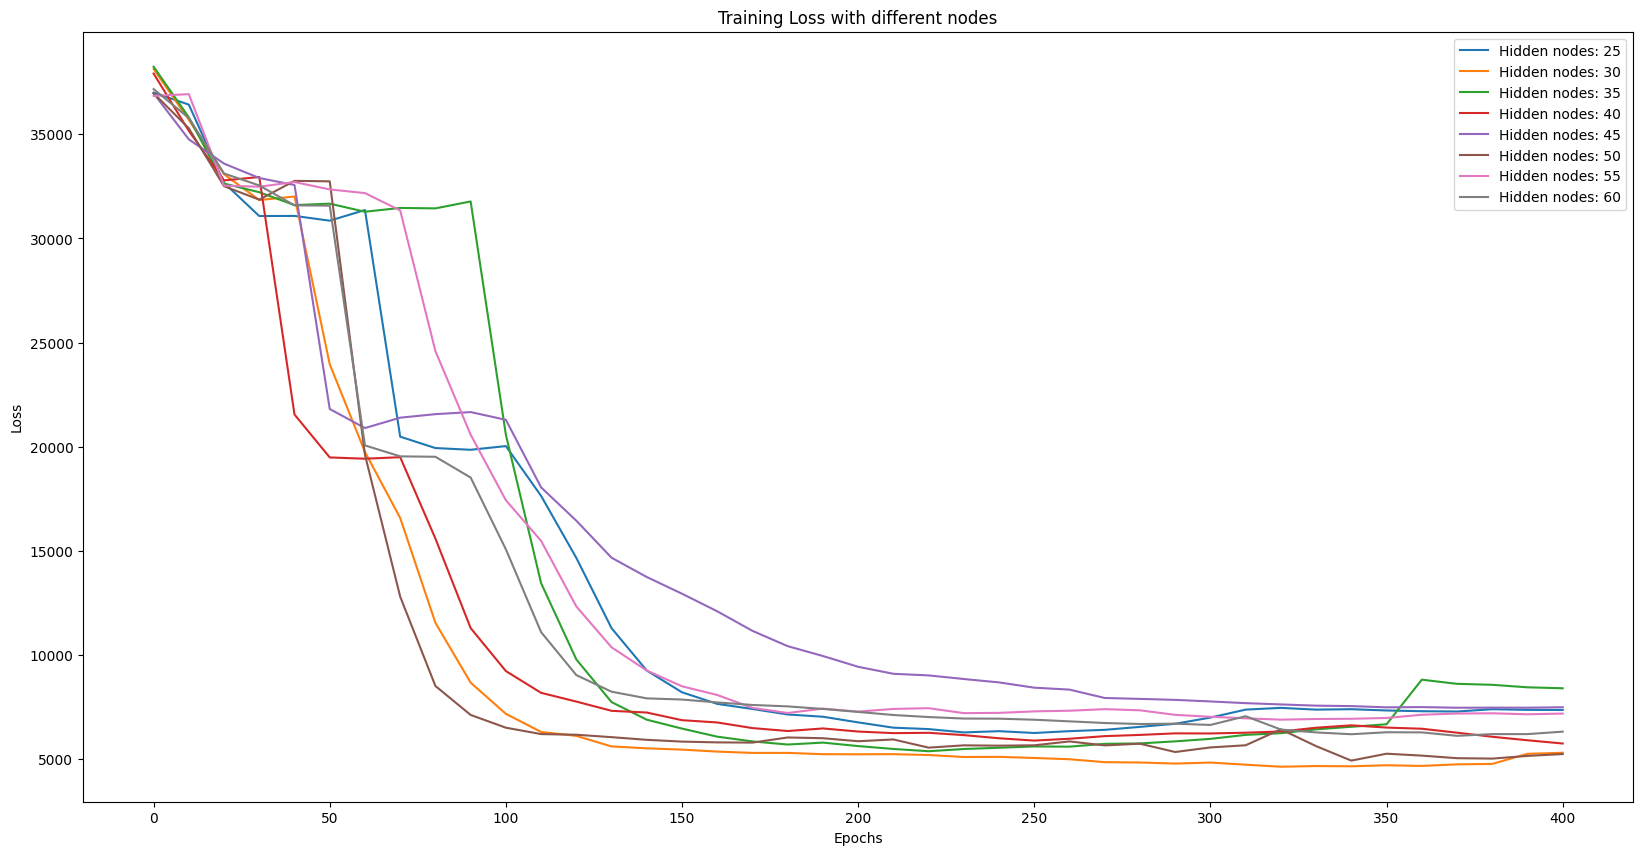

In [ ]:
plt.figure(figsize=(20, 10))
for hidden, losses in hidden_trained_losses.items():
    epochs = range(len(losses))
    epochs = [epoch * 10 for epoch in epochs]
    plt.plot(epochs, losses, label=f'Hidden nodes: {hidden}')
    plt.title('Training Loss with different nodes')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

for hidden, loss in hidden_avg_eval_losses.items():
    print(f'Average loss on test set on hidden : {hidden} nodes is {loss}')



Average difference between actual and predicted values on hidden nodes 25 is 65.58861340679522
Average difference between actual and predicted values on hidden nodes 30 is 98.79937557392103
Average difference between actual and predicted values on hidden nodes 35 is 89.7001331496786
Average difference between actual and predicted values on hidden nodes 40 is 67.62162993572086
Average difference between actual and predicted values on hidden nodes 45 is 72.64538108356291
Average difference between actual and predicted values on hidden nodes 50 is 95.91658402203858
Average difference between actual and predicted values on hidden nodes 55 is 68.92067952249771
Average difference between actual and predicted values on hidden nodes 60 is 64.90739669421488


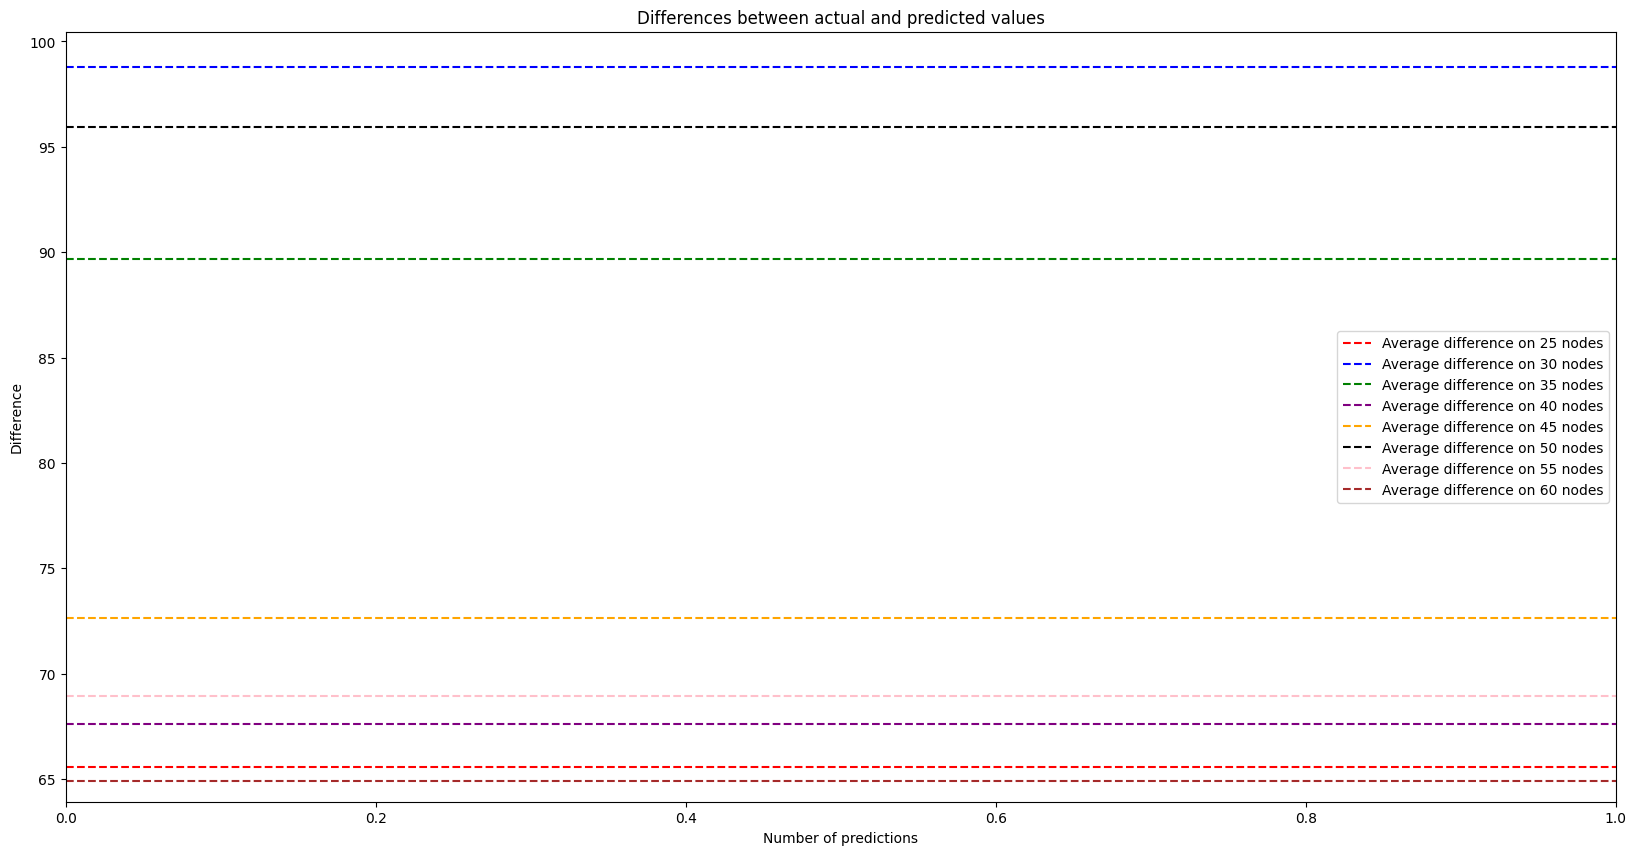

In [ ]:
# calculate differences between actual and predicted values
hidden_differences = {}
for hidden, predictions in hidden_predictited_values.items():
    hidden_differences[hidden] = [round(abs(y_test.iloc[i] - predictions[i]), 2) for i in range(len(y_test))]
    print(f'Average difference between actual and predicted values on hidden nodes {hidden} is {np.mean(hidden_differences[hidden])}')

colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'pink', 'brown']
index = 0
# plot differences
plt.figure(figsize=(20, 10))
for hidden, diff in hidden_differences.items():
    plt.axhline(y=np.mean(diff), color=colors[index], linestyle='dashed', label=f'Average difference on {hidden} nodes')
    plt.title('Differences between actual and predicted values')
    plt.legend()
    plt.xlabel('Number of predictions')
    plt.ylabel('Difference')

    index +=1


### Third test - testing learning rates (with 25 hidden nodes)
- 1 hidden layer
- relu activation function
- learirn rates from 0.01 to 0.2
- batch size = 32
- hidden nodes 50

In [ ]:
hidden_nodes = 25
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.15]

torch.manual_seed(RANDOM_SEED)

EPOCHS = 401

lr_trained_models = {}
lr_trained_losses = {}
lr_avg_eval_losses = {}
lr_predictited_values = {}

for lr in learning_rates:

    print(f'Training model with {lr} learning rate')

    trained_model = CNTBikeRentingPredictor(INPUT, hidden_nodes, OUTPUT).to(device)
    model_parameters = trained_model.parameters()
    optimizer = torch.optim.Adam(model_parameters, lr=lr)
    loss_fn = nn.MSELoss()

    # training
    trained_model, train_losses = train_model(trained_model, train_loader, optimizer, loss_fn, EPOCHS)

    # evaluation
    predictions, losses = evaluation(trained_model, test_loader, rmsle)

    lr_trained_models[lr] = trained_model
    lr_trained_losses[lr] = train_losses
    lr_avg_eval_losses[lr] = np.mean(losses)
    lr_predictited_values[lr] = predictions




Training model with 0.01 learning rate
Epoch: 0, Loss: 35727.33984375
Epoch: 10, Loss: 23785.296875
Epoch: 20, Loss: 20095.2109375
Epoch: 30, Loss: 18889.505859375
Epoch: 40, Loss: 18567.609375
Epoch: 50, Loss: 18279.384765625
Epoch: 60, Loss: 17907.54296875
Epoch: 70, Loss: 17789.96875
Epoch: 80, Loss: 17748.759765625
Epoch: 90, Loss: 17710.759765625
Epoch: 100, Loss: 17699.640625
Epoch: 110, Loss: 19292.4921875
Epoch: 120, Loss: 18957.328125
Epoch: 130, Loss: 19184.619140625
Epoch: 140, Loss: 19387.6796875
Epoch: 150, Loss: 19634.15234375
Epoch: 160, Loss: 19875.419921875
Epoch: 170, Loss: 20133.6953125
Epoch: 180, Loss: 20405.08984375
Epoch: 190, Loss: 20615.0703125
Epoch: 200, Loss: 20865.26171875
Epoch: 210, Loss: 21059.615234375
Epoch: 220, Loss: 21009.203125
Epoch: 230, Loss: 18026.060546875
Epoch: 240, Loss: 15603.97265625
Epoch: 250, Loss: 13471.419921875
Epoch: 260, Loss: 11875.134765625
Epoch: 270, Loss: 10475.916015625
Epoch: 280, Loss: 9332.513671875
Epoch: 290, Loss: 8213

Average loss on test set with learning rate : 0.01  is 0.7013813142824654
Average loss on test set with learning rate : 0.02  is 0.7184042235352338
Average loss on test set with learning rate : 0.03  is 0.8729922240540126
Average loss on test set with learning rate : 0.04  is 0.6353075022101949
Average loss on test set with learning rate : 0.05  is 0.666278239507211
Average loss on test set with learning rate : 0.08  is 0.9293955242666659
Average loss on test set with learning rate : 0.1  is 0.8739806806362475
Average loss on test set with learning rate : 0.15  is 0.776923624526699


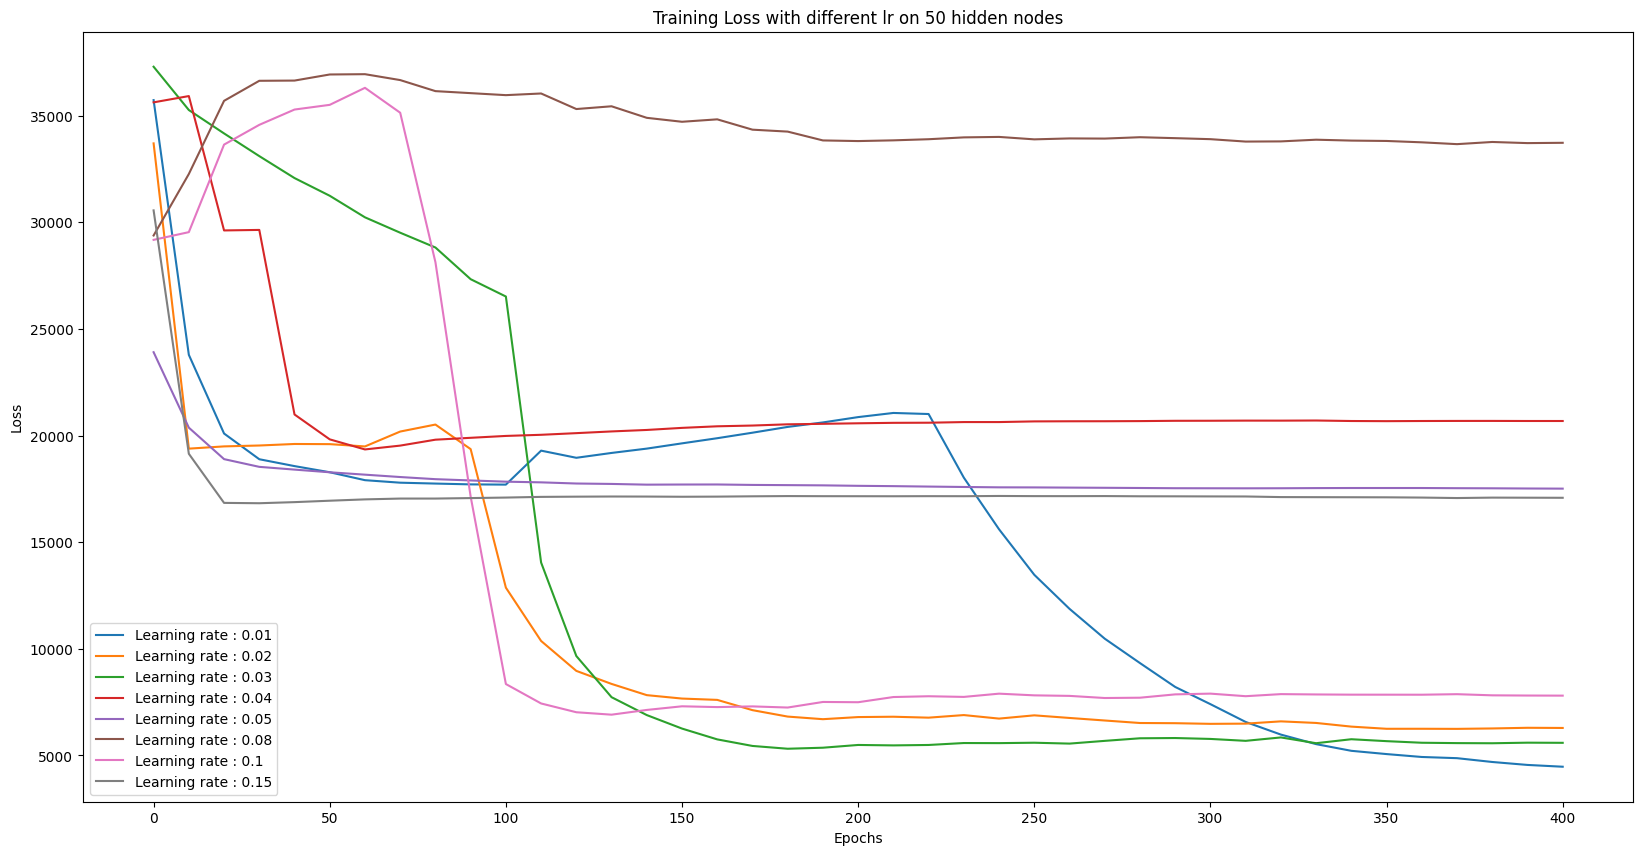

In [ ]:
plt.figure(figsize=(20, 10))
for lr, losses in lr_trained_losses.items():
    epochs = range(len(losses))
    epochs = [epoch * 10 for epoch in epochs]
    plt.plot(epochs, losses, label=f'Learning rate : {lr}')
    plt.title('Training Loss with different lr on 50 hidden nodes')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')


for lr, loss in lr_avg_eval_losses.items():
    print(f'Average loss on test set with learning rate : {lr}  is {loss}')


Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.01 is 65.86146005509643
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.02 is 67.02727272727273
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.03 is 91.23202479338843
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.04 is 77.86354912764004
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.05 is 83.14036730945821
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.08 is 116.03625344352616
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.1 is 92.13866850321396
Average difference between actual and predicted values with 25 hidden nodes and learning rate 0.15 is 94.46735537190082


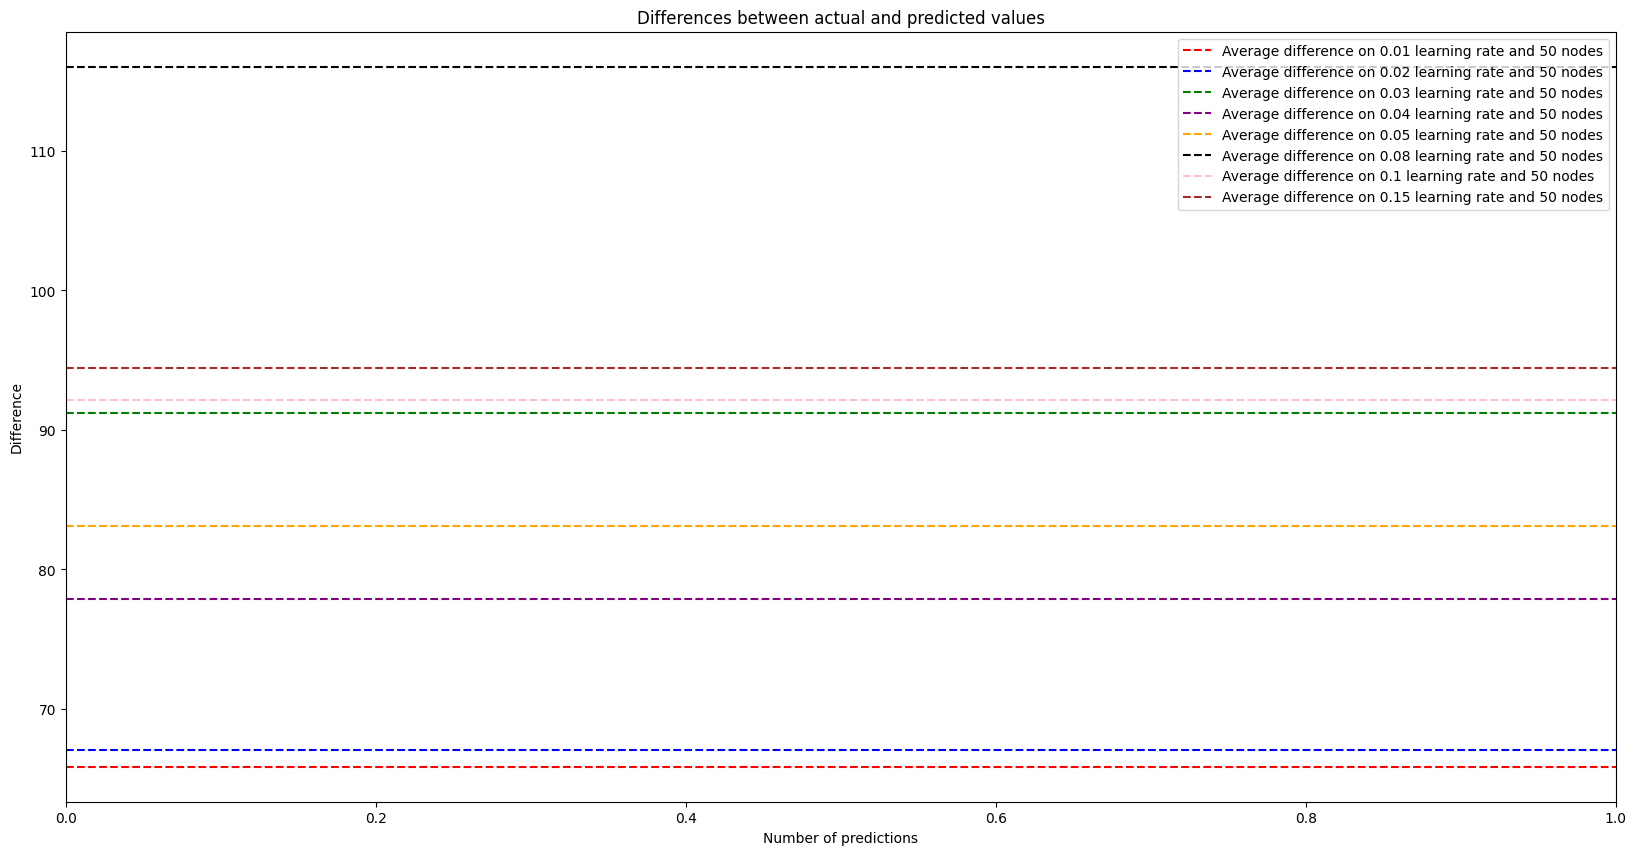

In [ ]:
# calculate differences between actual and predicted values
lr_differences = {}
for lr, predictions in lr_predictited_values.items():
    lr_differences[lr] = [round(abs(y_test.iloc[i] - predictions[i]), 2) for i in range(len(y_test))]
    print(f'Average difference between actual and predicted values with 25 hidden nodes and learning rate {lr} is {np.mean(lr_differences[lr])}')

colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'pink', 'brown']
index = 0
# plot differences
plt.figure(figsize=(20, 10))
for lr, diff in lr_differences.items():
    plt.axhline(y=np.mean(diff), color=colors[index], linestyle='dashed', label=f'Average difference on {lr} learning rate and 50 nodes')
    plt.title('Differences between actual and predicted values')
    plt.legend()
    plt.xlabel('Number of predictions')
    plt.ylabel('Difference')

    index +=1



## Testing with 2 layers and with 3 layers
- 25 hidden nodes
- lr = 0.02

In [ ]:
class CNTBikeRentingPredictorTwoLayers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNTBikeRentingPredictorTwoLayers, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.output_size)
        self.actv = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.fc3(x)
        return x


class CNTBikeRentingPredictorThreeLayers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNTBikeRentingPredictorThreeLayers, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.hidden_size//4)
        self.fc4 = nn.Linear(self.hidden_size//4, self.output_size)
        self.actv = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.fc3(x)
        x = self.actv(x)
        x = self.fc4(x)
        return x


In [ ]:
INPUT = cnt_cleaned_dataset.shape[1] - 1
HIDDEN = 25
OUTPUT = 1

EPOCHS = 401
BATCH_SIZE = 32
LR = 0.02

# seed
torch.manual_seed(42)

# models
cnt_model = CNTBikeRentingPredictor(INPUT, HIDDEN, OUTPUT).to(device)
cnt_model_2_layers = CNTBikeRentingPredictorTwoLayers(INPUT, HIDDEN, OUTPUT).to(device)
cnt_model_3_layers = CNTBikeRentingPredictorThreeLayers(INPUT, HIDDEN, OUTPUT).to(device)

# parameters
model_parameters_1 = cnt_model.parameters()
model_parameters_2 = cnt_model_2_layers.parameters()
model_parameters_3 = cnt_model_3_layers.parameters()

optimizer_1 = torch.optim.Adam(model_parameters_1, lr=LR)
optimizer_2 = torch.optim.Adam(model_parameters_2, lr=LR)
optimizer_3 = torch.optim.Adam(model_parameters_3, lr=LR)
loss_fn = nn.MSELoss()

# training set
train_dataset = create_tensor_dataset(cnt_cleaned_dataset, device=device)
train_loader = create_dataloader(train_dataset, BATCH_SIZE)


# evaluation
test_dataset = TensorDataset(torch.from_numpy(x_test.values).float().to(device), torch.from_numpy(y_test.values).float().to(device))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Epoch: 0, Loss: 37001.796875
Epoch: 10, Loss: 36427.8671875
Epoch: 20, Loss: 32670.12890625
Epoch: 30, Loss: 31077.71875
Epoch: 40, Loss: 31083.92578125
Epoch: 50, Loss: 30855.068359375
Epoch: 60, Loss: 31366.703125
Epoch: 70, Loss: 20485.34375
Epoch: 80, Loss: 19938.546875
Epoch: 90, Loss: 19856.26171875
Epoch: 100, Loss: 20033.650390625
Epoch: 110, Loss: 17641.373046875
Epoch: 120, Loss: 14665.0107421875
Epoch: 130, Loss: 11291.7373046875
Epoch: 140, Loss: 9256.05078125
Epoch: 150, Loss: 8213.9755859375
Epoch: 160, Loss: 7656.58349609375
Epoch: 170, Loss: 7412.8154296875
Epoch: 180, Loss: 7148.34521484375
Epoch: 190, Loss: 7040.3447265625
Epoch: 200, Loss: 6768.5400390625
Epoch: 210, Loss: 6514.810546875
Epoch: 220, Loss: 6447.07568359375
Epoch: 230, Loss: 6286.59912109375
Epoch: 240, Loss: 6347.484375
Epoch: 250, Loss: 6259.6044921875
Epoch: 260, Loss: 6348.37060546875
Epoch: 270, Loss: 6410.36083984375
Epoch: 280, Loss: 6553.88037109375
Epoch: 290, Loss: 6702.1357421875
Epoch: 300,

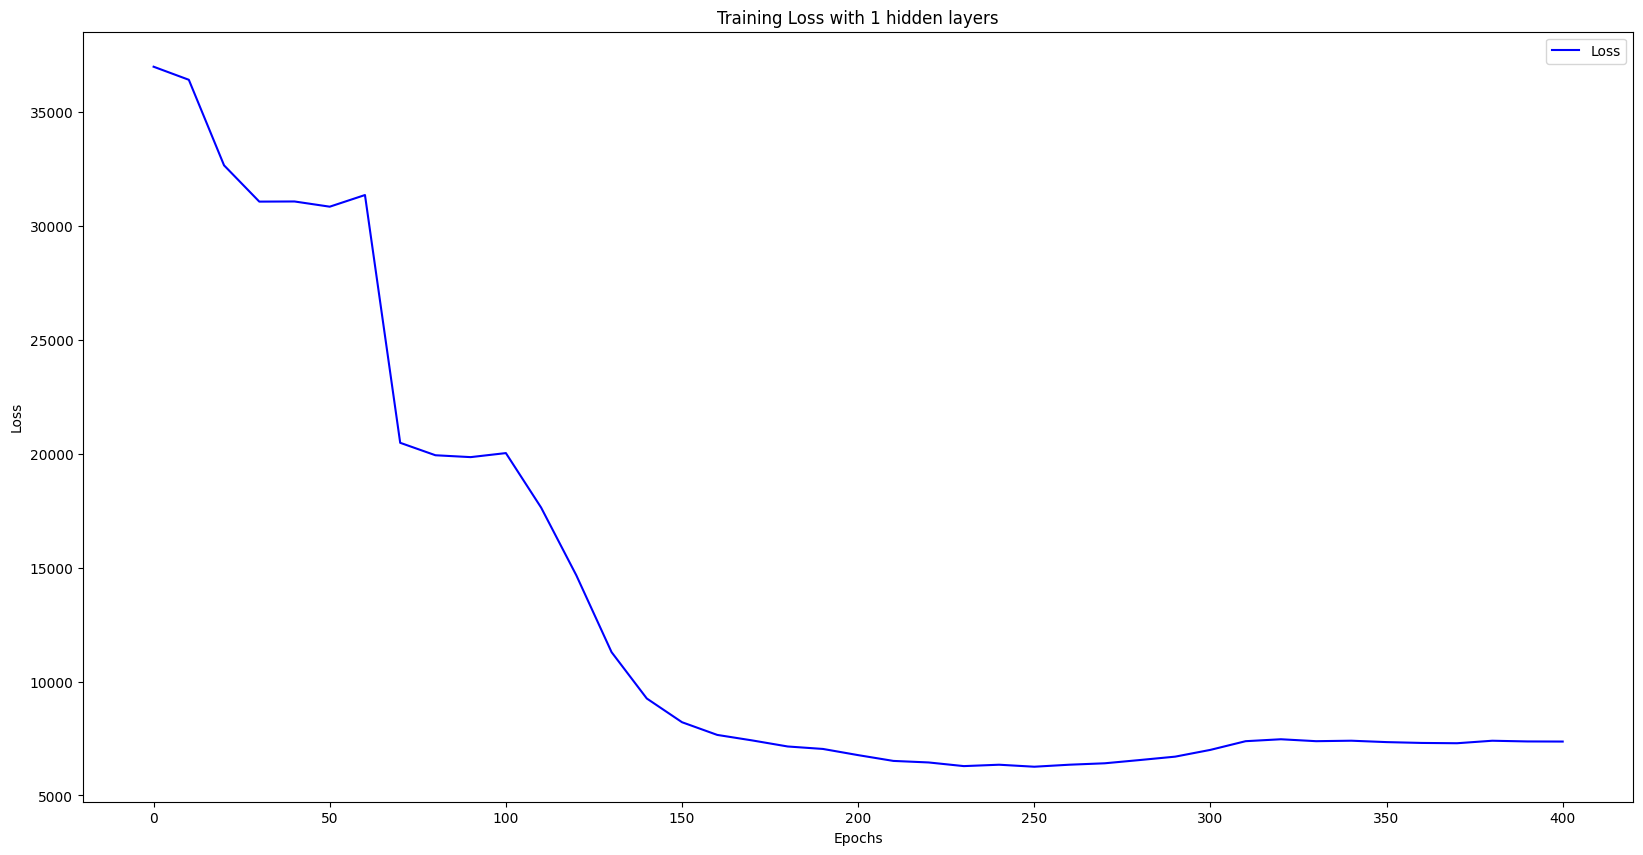

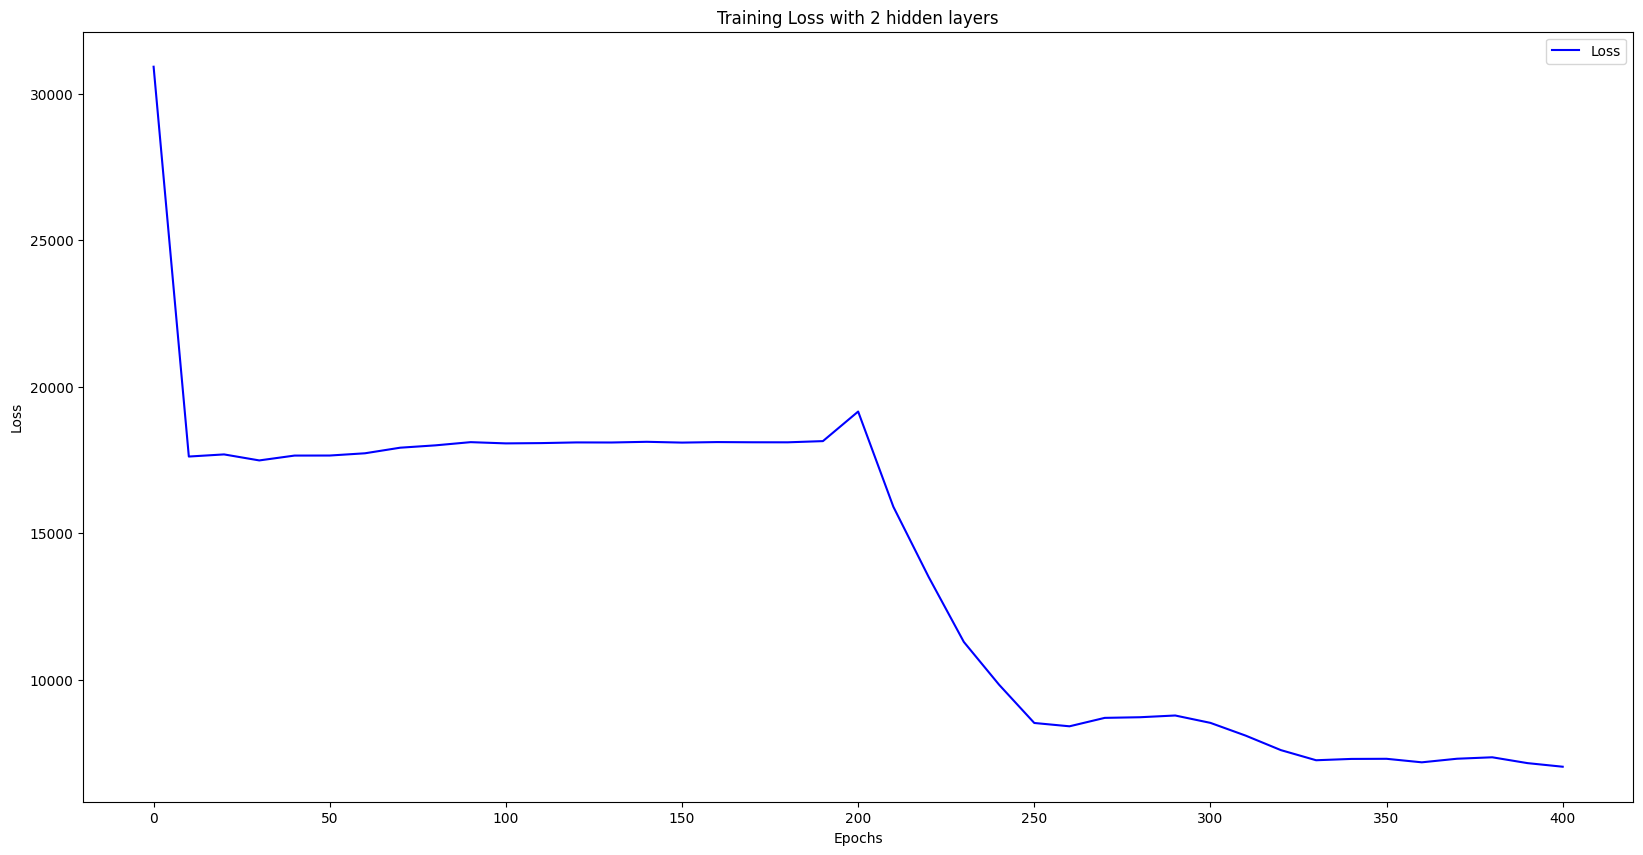

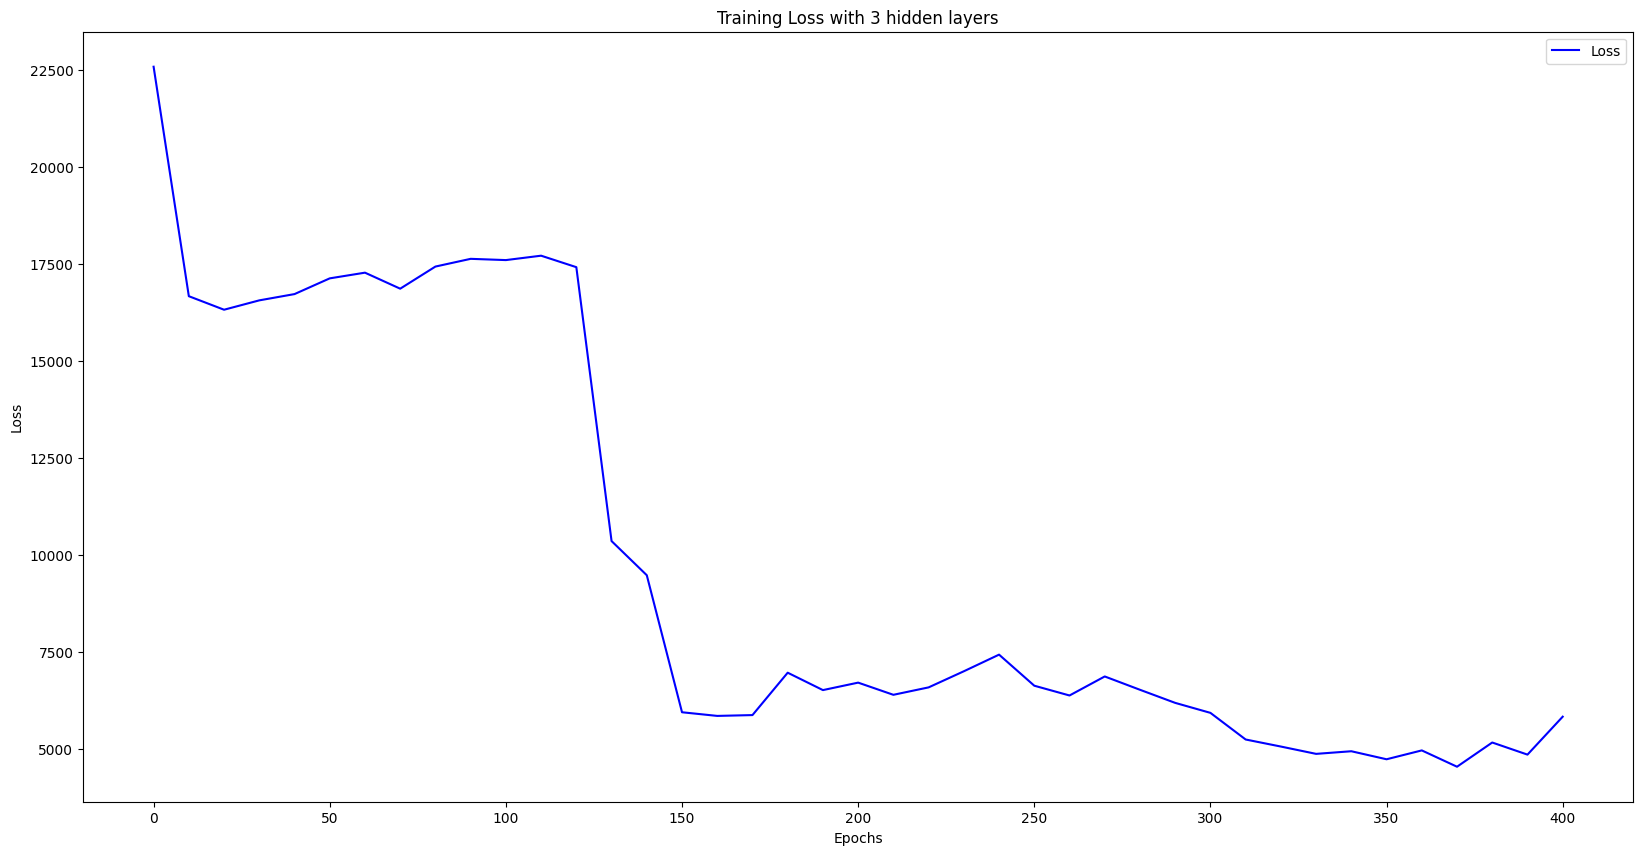

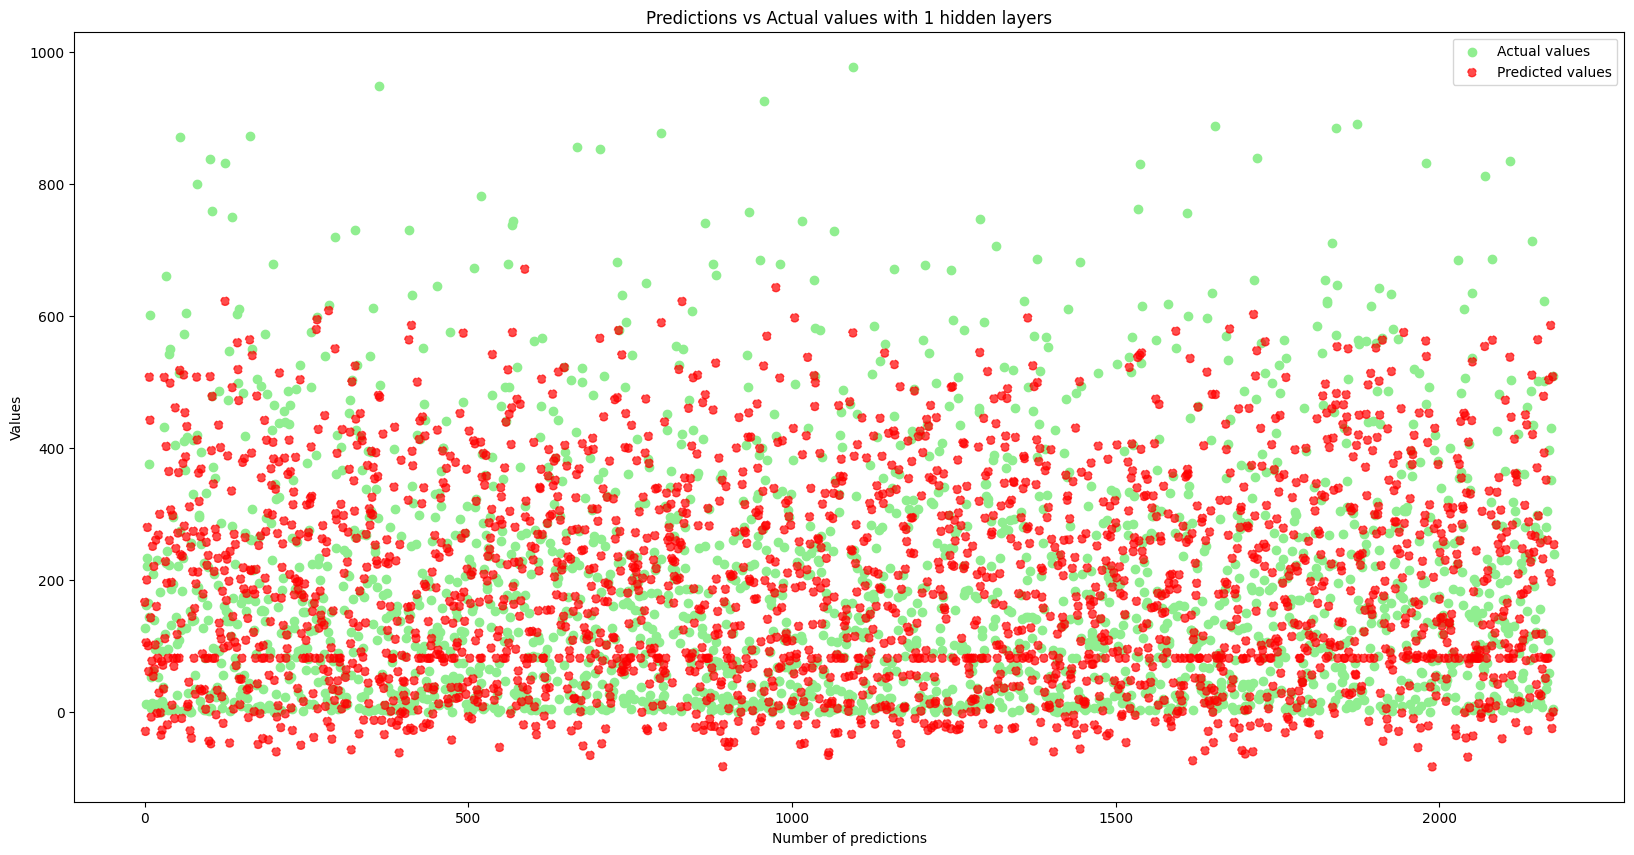

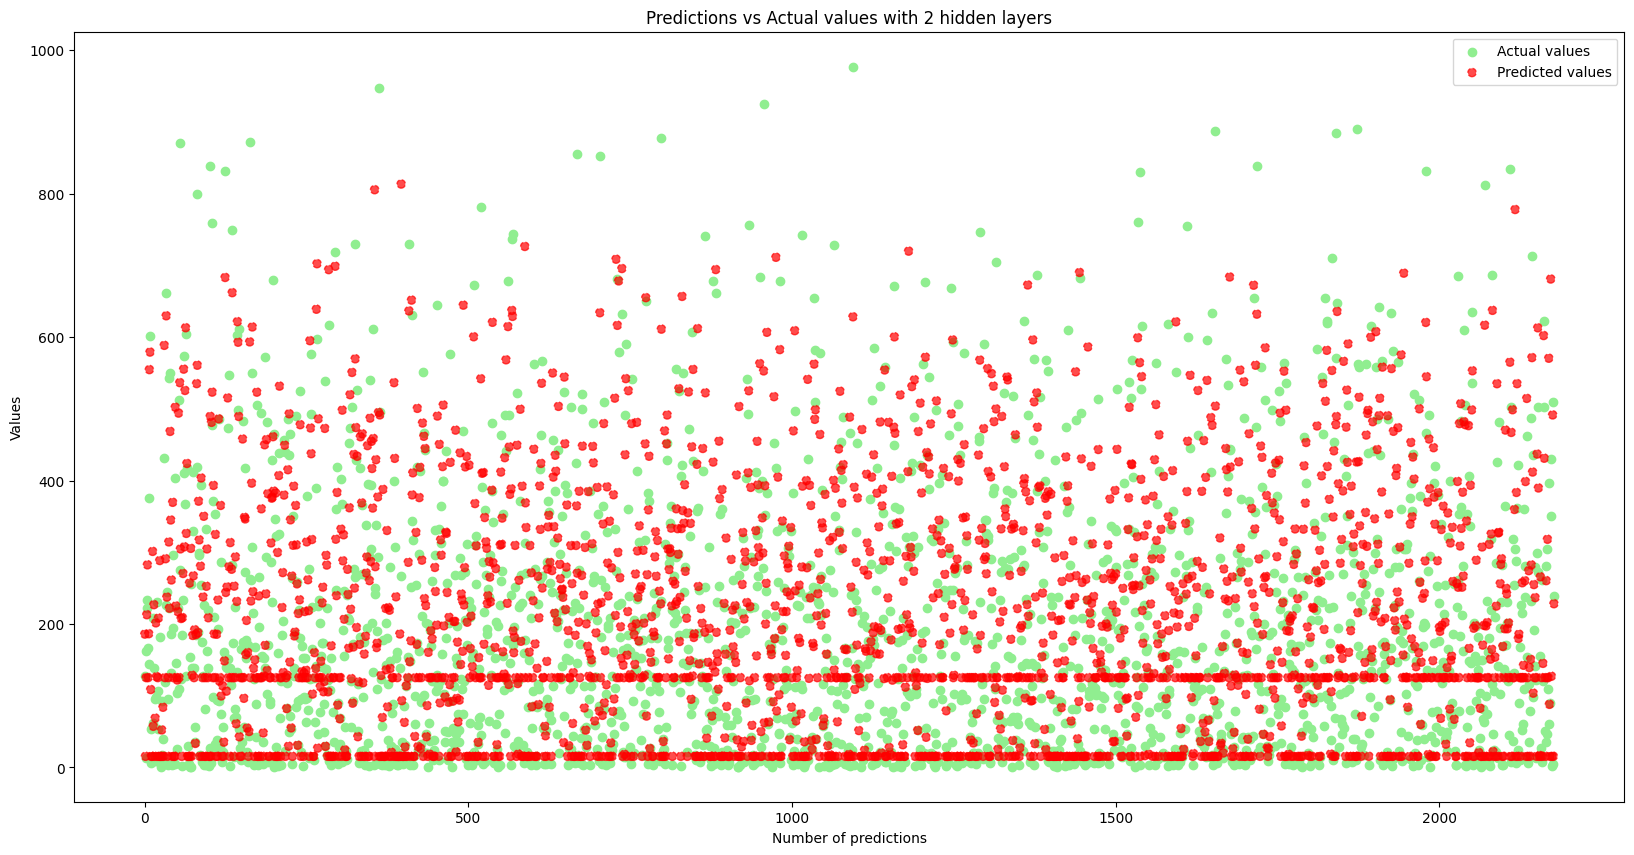

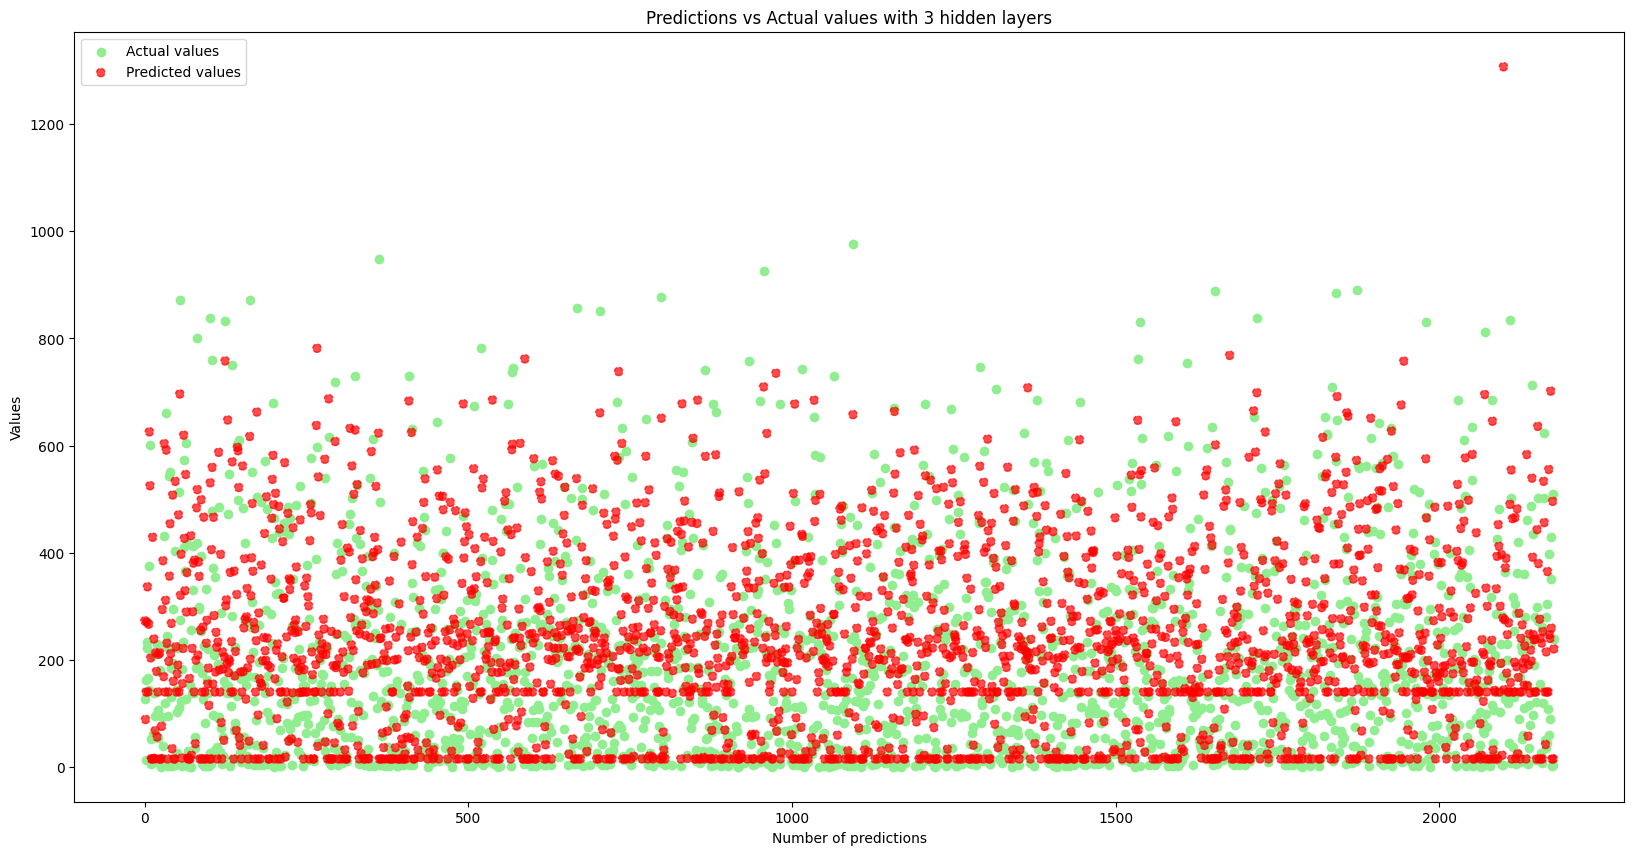

In [ ]:
# training
cnt_model_trained, train_losses_1_layer = train_model(cnt_model, train_loader, optimizer_1, loss_fn, EPOCHS)
cnt_model_2, train_losses_2_layers = train_model(cnt_model_2_layers, train_loader, optimizer_2, loss_fn, EPOCHS)
cnt_model_3, train_losses_3_layers = train_model(cnt_model_3_layers, train_loader, optimizer_3, loss_fn, EPOCHS)

# evaluation
predictions_1_layers, losses_1_layers = evaluation(cnt_model_trained, test_loader, rmsle)
predictions_2_layers, losses_2_layers = evaluation(cnt_model_2, test_loader, rmsle)
predictions_3_layers, losses_3_layers = evaluation(cnt_model_3, test_loader, rmsle)

# plotting
losses = [train_losses_1_layer, train_losses_2_layers, train_losses_3_layers]
layers = [1, 2, 3]
predictions = [predictions_1_layers, predictions_2_layers, predictions_3_layers]
i = 0

for train_loss in losses:
  plot_loss(train_loss, f'Training Loss with {layers[i]} hidden layers')
  i += 1

i = 0
for preds in predictions:
  plot_predictions(y_test, preds, f'Predictions vs Actual values with {layers[i]} hidden layers')
  i += 1

# Scroll the output to see the plots

In [ ]:
one_layer_test_loss = np.mean(losses_1_layers)
two_layer_test_loss = np.mean(losses_2_layers)
three_layer_test_loss = np.mean(losses_3_layers)

print(f"Average loss with one layer on test set : {one_layer_test_loss}")
print(f"Average loss with two layers on test set : {two_layer_test_loss} ")
print(f"Average loss with three layers on test set : {three_layer_test_loss}")

Average loss with one layer on test set : 0.6546600516834207
Average loss with two layers on test set : 0.4708373103260009 
Average loss with three layers on test set : 0.6381676963319244


#### Predictions comparasion between different structures on subset on y_test

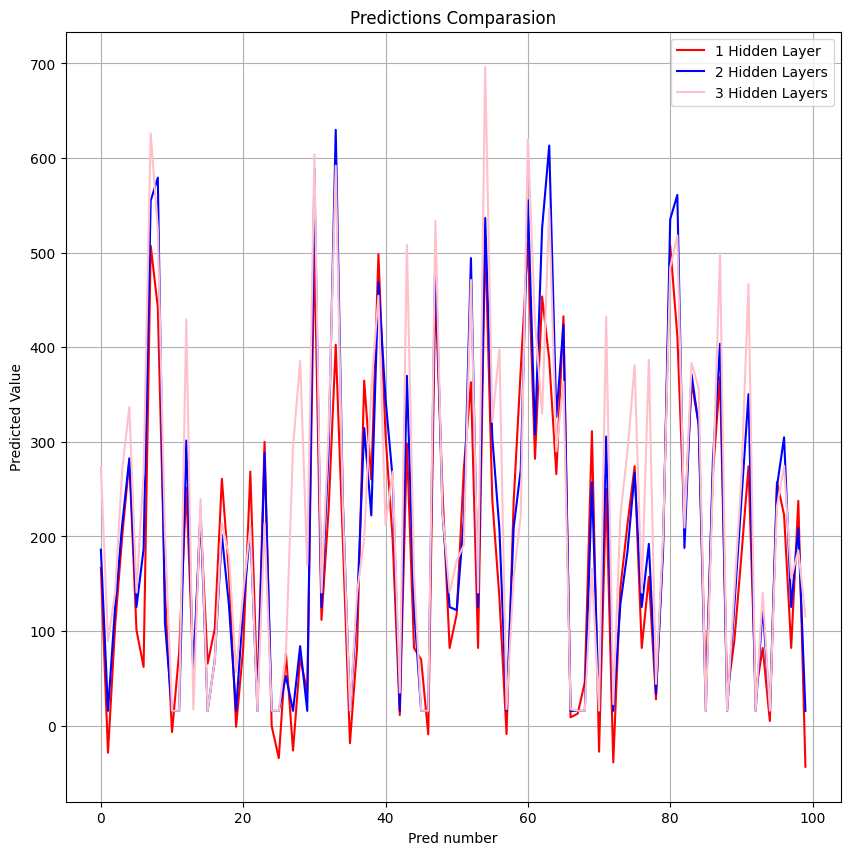

In [ ]:
true_values = y_test[:100]
one_layer =  predictions_1_layers[:100]
two_layers = predictions_2_layers[:100]
three_layers = predictions_3_layers[0:100]

num_sample = [_ for _ in range(len(true_values))]

plt.figure(figsize=(10,10))
plt.title("Predictions Comparasion")
plt.xlabel("Pred number")
plt.ylabel("Predicted Value")
plt.plot(num_sample, one_layer, color='red', label="1 Hidden Layer")
plt.plot(num_sample, two_layers, color='blue', label="2 Hidden Layers")
plt.plot(num_sample, three_layers, color='pink', label="3 Hidden Layers")
plt.legend()
plt.grid(True)
plt.show()

# 2. Separating bikes from registered users and unregistered users

#### Spliting values

In [13]:
RANDOM_STATE = 42

torch.manual_seed(RANDOM_SEED)

# cnt_cleaned_dataset train and test set
x_train_casual, x_test_casual, y_train_casual, y_test_casual = split_data(casual_dataset, 0.2, RANDOM_STATE)
x_train_registered, x_test_registered, y_train_registered, y_test_registered = split_data(registered_dataset, 0.2, RANDOM_STATE)



In [30]:
x_train_registered == x_train_casual

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
2815,True,True,True,True,True,True,True,True,True,True,True,True
8695,True,True,True,True,True,True,True,True,True,True,True,True
8406,True,True,True,True,True,True,True,True,True,True,True,True
1543,True,True,True,True,True,True,True,True,True,True,True,True
4952,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,True,True,True,True,True,True,True,True,True,True,True,True
5191,True,True,True,True,True,True,True,True,True,True,True,True
5390,True,True,True,True,True,True,True,True,True,True,True,True
860,True,True,True,True,True,True,True,True,True,True,True,True


In [14]:
class SplittedPredictionsModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SplittedPredictionsModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.output_size)
        self.actv = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.fc3(x)
        return x


In [19]:
INPUT = cnt_cleaned_dataset.shape[1] - 1
HIDDEN = 25
OUTPUT = 1

EPOCHS = 300
BATCH_SIZE = 32
LR = 0.02


# casual
casual_model = SplittedPredictionsModel(INPUT, HIDDEN, OUTPUT).to(device)
casual_parameters = casual_model.parameters()
casual_optimizer = torch.optim.Adam(params=casual_parameters, lr=LR)

train_dataset_casual = TensorDataset(torch.from_numpy(x_train_casual.values).float().to(device), torch.from_numpy(y_train_casual.values).float().to(device))
train_loader_casual = DataLoader(train_dataset_casual, batch_size=BATCH_SIZE, shuffle=False)

# registered
registered_model = SplittedPredictionsModel(INPUT, HIDDEN, OUTPUT).to(device)
registered_parameters = registered_model.parameters()
registered_optimizer = torch.optim.Adam(params=registered_parameters, lr=LR)

train_dataset_reg = TensorDataset(torch.from_numpy(x_train_registered.values).float().to(device), torch.from_numpy(y_train_registered.values).float().to(device))
train_loader_reg = DataLoader(train_dataset_casual, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.MSELoss()

# test laoders
test_dataset_casual = TensorDataset(torch.from_numpy(x_test_casual.values).float().to(device), torch.from_numpy(y_test_casual.values).float().to(device))
test_loader_casual = DataLoader(test_dataset_casual, batch_size=1, shuffle=False)

test_dataset_reg = TensorDataset(torch.from_numpy(x_test_registered.values).float().to(device), torch.from_numpy(y_test_registered.values).float().to(device))
test_loader_reg = DataLoader(test_dataset_reg, batch_size=1, shuffle=False)

In [20]:
# train models
casual_trained, casual_loses = train_model(casual_model, train_loader_casual, casual_optimizer, loss_fn, EPOCHS)
registered_trained, registered_losses = train_model(registered_model, train_loader_reg, registered_optimizer, loss_fn, EPOCHS)

# evaluation
preds_casual, losses_casual_test = evaluation(casual_trained, test_loader_casual, rmsle)
preds_registered, losses_registered_test = evaluation(registered_trained, test_loader_reg, rmsle)

Epoch: 0, Loss: 606.4949951171875
Epoch: 10, Loss: 149.33807373046875
Epoch: 20, Loss: 62.93714141845703
Epoch: 30, Loss: 17.822643280029297
Epoch: 40, Loss: 33.0096435546875
Epoch: 50, Loss: 46.756492614746094
Epoch: 60, Loss: 33.88226318359375
Epoch: 70, Loss: 24.301021575927734
Epoch: 80, Loss: 5.014432430267334
Epoch: 90, Loss: 4.940083980560303
Epoch: 100, Loss: 34.31135559082031
Epoch: 110, Loss: 37.35259246826172
Epoch: 120, Loss: 41.475341796875
Epoch: 130, Loss: 66.87674713134766
Epoch: 140, Loss: 35.235084533691406
Epoch: 150, Loss: 15.33325481414795
Epoch: 160, Loss: 51.09773254394531
Epoch: 170, Loss: 32.583580017089844
Epoch: 180, Loss: 47.606651306152344
Epoch: 190, Loss: 73.58312225341797
Epoch: 200, Loss: 42.87566375732422
Epoch: 210, Loss: 23.274028778076172
Epoch: 220, Loss: 20.79067611694336
Epoch: 230, Loss: 28.370258331298828
Epoch: 240, Loss: 19.157737731933594
Epoch: 250, Loss: 6.2095160484313965
Epoch: 260, Loss: 20.709224700927734
Epoch: 270, Loss: 8.7346944808

In [21]:
average_loss_on_casual = np.mean(losses_casual_test)
average_loss_on_registered = np.mean(losses_registered_test)

print(f"Average loss on causal : {average_loss_on_casual}")
print(f"Average loss on registered : {average_loss_on_registered}")

Average loss on causal : 0.5628200541733601
Average loss on registered : 1.5161838360178679


In [31]:
# plot predictions
total_predictions = np.array(preds_casual) + np.array(preds_registered)

correct_values = np.array(y_test_casual) + np.array(y_test_registered)

# get average_differance
avg_difference = np.mean(np.abs(correct_values - total_predictions))
print(f"Avg differance is : {avg_difference}")

Avg differance is : 121.1346882429552


# Conclusions


### Predicting only total number
- After trying different setups with two hidden layers I choose 25 hidden layers as well as learning rate at 0.02 to test different architectures
- Architecture with one hidden layer and 3 hidden layers had similar average error around 0.65 wich is twice as good as selecting at random
- Architecture with 2 hidden layers outperformed previous one with average error around 0.47
- It is to expensive to calculate all differrent structures but the average loss of 0.47 it's a good result


### Predicting casual and registered numbers
- Based on results from predicting with total numbers I chose to compare architecture with one layer to architecture woth two layers
- At the very start we can see that the losses achived while training on casual and regstered numbers are way smaller -> but the numbers are also smaller, so that might be a reason
- We can see that the average loss on registered and casual is between 0.56 to 1.51
- Average distance on predictions is way bigger than when only trying to predict total number : 121 compared to 60-80

### Final thoughts
- In our tests, the best results we achived with model that predicted total numbers of rented bikes
- I guess that it is posible to reach even better results if we check more architectures and more possibilities